Course: WI4011-17 Computational Fluid Dynamics

Author: Bradley van Hoof, Leonardo Alessandro Lüder, Rosa Calegari

Academic year: 2023/2024

Delft University of Technology

In [1]:
import numpy
import numpy as np
import scipy.sparse
import scipy.linalg
from matplotlib import pyplot as plt
import os

In [2]:
def generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y):
    
    n_vertices_x = n_cells_x + 1
    n_vertices_y = n_cells_y + 1
    n_cells = n_cells_x * n_cells_y

    x, y = numpy.meshgrid(numpy.linspace(x_min, x_max, n_vertices_x), numpy.linspace(y_min, y_max, n_vertices_y))
    vertices = numpy.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

    cells = numpy.zeros([n_cells, 4], dtype=numpy.int64)
    for j in range(0, n_cells_y):
        for i in range(0, n_cells_x):
            k = i + n_cells_x*j  

            cells[k, 0] = (i) + (n_cells_x + 1)*(j)  # the linear index of the lower left corner of the element
            cells[k, 1] = (i+1) + (n_cells_x + 1)*(j)  # the linear index of the lower right corner of the element
            cells[k, 2] = (i) + (n_cells_x + 1)*(j+1)  # the linear index of the upper right corner of the element
            cells[k, 3] = (i+1) + (n_cells_x + 1)*(j+1)  # the linear index of the upper right corner of the element

    return vertices, cells

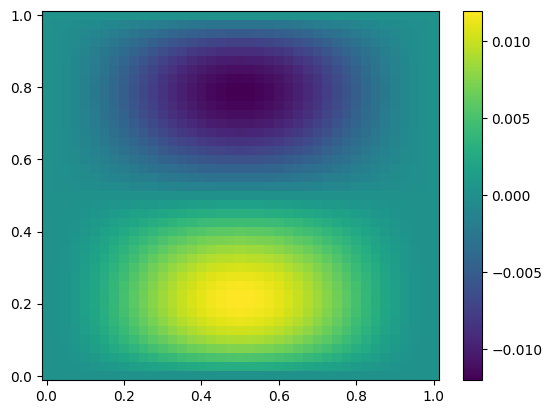

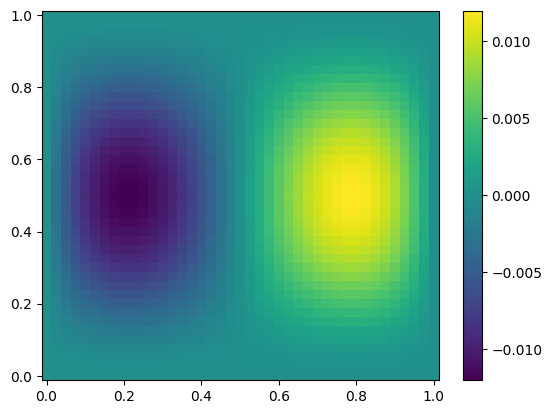

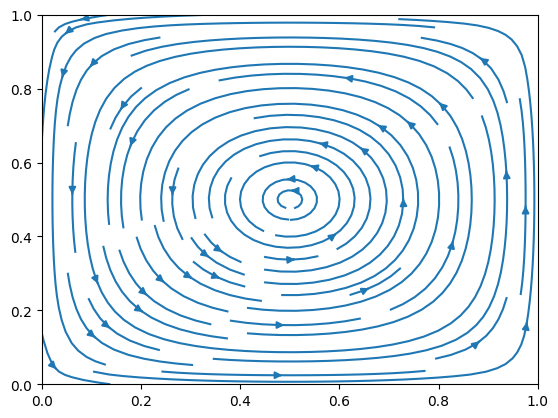

In [3]:
x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 1.0

n_cells_x = n_cells_y = 40

vertices, cells = generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y)

def u_1(x, y):
    return x**2 * ((1-x)**2) * (2*y-6*y**2+4*y**3)
def u_2(x, y):
    return -y**2 * ((1-y)**2) *(2*x-6*x**2+4*x**3)
def p(x, y=0):
    return x*(1-x)

def calc_u_1(vertices):
    
    return u_1(vertices[:,0], vertices[:,1])
def calc_u_2(vertices):
    return u_2(vertices[:,0], vertices[:,1])
def calc_p(vertices):
    return p(vertices[:,0], vertices[:,1])

u_1_values = calc_u_1(vertices)
u_2_values = calc_u_2(vertices)
p_values = calc_p(vertices)

# Reshape vertices and values
x = vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1)
y = vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1)
u1 = u_1_values.reshape(n_cells_y+1, n_cells_x+1)
u2 = u_2_values.reshape(n_cells_y+1, n_cells_x+1)



plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), u_1_values.reshape(n_cells_y+1, n_cells_x+1)) 
plt.colorbar()
plt.show()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), u_2_values.reshape(n_cells_y+1, n_cells_x+1))
plt.colorbar()
plt.show()
plt.streamplot(x, y, u1, u2)
plt.show()



plt.show()

In [4]:
def compute_local_mass_matrix():
    """Int_omega BiBk dx = Int_Omega BjBl dy; Multiply by h"""
    M_local = numpy.zeros([2, 2])
    M_local[0, 0] = 0.5
    M_local[1, 1] = 0.5
    
    return M_local

def compute_local_stiffness_matrix():
    """Int_omega Bix Bkx dx = Int_Omega Bjy Bly dy; Multiply by 1/h"""
    N_local = numpy.ones([2, 2])
    N_local[0, 1] = -1.0
    N_local[1, 0] = -1.0
    
    return N_local

def compute_local_advection_matrix():
    """Int_omega Bix Bk dx = Int_Omega Bjy Bl dy; Multiply by 1"""
    A_local = 0.5*numpy.ones([2, 2])
    A_local[0, 0] = -0.5
    A_local[1, 0] = -0.5
    
    return A_local

In [5]:
def compute_A1_and_A2_local():
    A1_A2 = numpy.zeros([4, 4])
    S_local_1D = compute_local_stiffness_matrix()
    M_local_1D = compute_local_mass_matrix()
    A1_A2 = numpy.kron(S_local_1D, M_local_1D) + numpy.kron(M_local_1D, S_local_1D)
    return A1_A2

def compute_G1_local():
    G_local = numpy.zeros([4, 4])
    A_local = compute_local_advection_matrix()
    M_local = compute_local_mass_matrix()
    G_local = numpy.kron(M_local, A_local) #+ numpy.kron(M_local, A_local)
    return G_local

def compute_G2_local():
    G_local = numpy.zeros([4, 4])
    A_local = compute_local_advection_matrix()
    M_local = compute_local_mass_matrix()
    G_local = numpy.kron(A_local, M_local) #+ numpy.kron(A_local, M_local)
    return G_local


In [6]:
def compute_global_A_1_A_2(vertices, cells):

    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]

    N_row_idx = numpy.zeros([n_cells, 4, 4])
    N_col_idx = numpy.zeros([n_cells, 4, 4]) 
    N_data = numpy.zeros([n_cells, 4, 4])

    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()

    A_local = compute_A1_and_A2_local()

    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx
        N_data[cell_idx, :, :] = A_local
    
    N_global = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))
    
    A = scipy.sparse.bmat([[N_global, None], [None, N_global]])

    return A.tocsr(), N_global 


def compute_global_G(vertices, cells):

    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]

    N_row_idx = numpy.zeros([n_cells, 4, 4])
    N_col_idx = numpy.zeros([n_cells, 4, 4]) 
    N_data = numpy.zeros([n_cells, 4, 4])

    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()

    G1_local = compute_G1_local()
    G2_local = compute_G2_local()

    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx

        N_data[cell_idx, :, :] = G1_local * delta_x[cell_idx]

    G_1 = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))

    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx

        N_data[cell_idx, :, :] = G2_local * delta_y[cell_idx]
        
    G_2 = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))

    G = scipy.sparse.bmat([[G_1], [G_2]])

    B = scipy.sparse.bmat([[G_1.T, G_2.T]])
    return G.tocsr(), G_1, G_2, -B

def assemble_global_matrix(vertices, cells):
    A = compute_global_A_1_A_2(vertices, cells)[0]
    G = compute_global_G(vertices, cells)[0]
    B = compute_global_G(vertices, cells)[3]
    M = scipy.sparse.bmat([[A, -G], [B, None]])

    return M.tocsr()

In [7]:
f_1 = lambda x,y: -4 *(6* x**2 - 6* x + 1)* y* (2* y**2 - 3* y + 1) - 12* (1 - x)**2 *x**2* (-1 + 2* y) + 1-2 *x
f_2 = lambda x,y: 12* (2* x - 1) *(1 - y)**2* y**2 + 4* x *(1 - 3* x + 2* x**2)* (1 - 6 *y + 6 *y**2)
g = lambda x,y: 0

def compute_forcing_term_2D(f_1, f_2, g, vertices, cells):
    
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()
    
    F1 = numpy.zeros(n_vertices)
    F2 = numpy.zeros(n_vertices)
    F3 = numpy.zeros(n_vertices)
    

    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f_1(vertices[cell][:,0],vertices[cell][:,1])
        F1[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]

    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f_2(vertices[cell][:,0],vertices[cell][:,1])
        F2[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]

    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = g(vertices[cell][:,0],vertices[cell][:,1])
        F3[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]

    
    return F1, F2, F3

In [8]:
def solve_Stokes(f_1, f_2, g, phi_left, phi_right, phi_bottom, phi_top, n_cells_x, n_cells_y, vertices, cells, lam, penalty = True):

    A1 = compute_global_A_1_A_2(vertices, cells)[1]
    A2 = A1.copy()
    G1 = compute_global_G(vertices, cells)[1]
    G2 = compute_global_G(vertices, cells)[2]
    B1 = -G1.T
    B2 = -G2.T
   
    #rhs
    F1, F2, F3= compute_forcing_term_2D(f_1, f_2, g, vertices, cells)
    
    def handle_boundary(i_idx, j_idx, matrices, phi):
        basis_indices = i_idx + (n_cells_x + 1)*j_idx
        for matrix in matrices:
            matrix[basis_indices, :] = 0.0
            matrix[basis_indices, basis_indices] = 1.0
        F1[basis_indices] = F2[basis_indices] = phi
        return matrices
    
    matrices = [A1, A2, G1, G2, B1, B2]
    
    # Left boundary
    i_idx = numpy.zeros(n_cells_y + 1, dtype=numpy.int64)
    j_idx = numpy.arange(0, n_cells_y + 1)
    matrices = handle_boundary(i_idx, j_idx, matrices, phi_left)
    
    # Right boundary
    i_idx = n_cells_x*numpy.ones(n_cells_y + 1, dtype=numpy.int64)
    j_idx = numpy.arange(0, n_cells_y + 1)
    matrices = handle_boundary(i_idx, j_idx, matrices, phi_left)
    
    # Bottom boundary
    i_idx = numpy.arange(0, n_cells_x + 1)
    j_idx = numpy.zeros(n_cells_x + 1, dtype=numpy.int64)
    matrices = handle_boundary(i_idx, j_idx, matrices, phi_left)
    
    # Top boundary
    i_idx = numpy.arange(0, n_cells_x + 1)
    j_idx = n_cells_y*numpy.ones(n_cells_x + 1, dtype=numpy.int64)
    matrices = handle_boundary(i_idx, j_idx, matrices, phi_left)

    if penalty == True:

        penalty = 1/lam *numpy.eye((n_cells_x + 1)*(n_cells_y + 1))
        S_pen = scipy.sparse.bmat([[A1,None, G1], [None, A2, G2], [B1, B2, penalty]]).tocsr()
        F = numpy.hstack([F1, F2, F3])

        Solution = scipy.sparse.linalg.spsolve(S_pen, F)
        
        u_12 = Solution[:2*vertices.shape[0]]
        BB = scipy.sparse.bmat([[B1, B2]]).tocsr()
        Divergence = BB.dot(u_12)

        return Solution, S_pen, Divergence


    else:
        S = scipy.sparse.bmat([[A1,None, G1], [None, A2, G2], [B1, B2, None]]).tocsr()
        
        F = numpy.hstack([F1, F2, F3])
        Solution = scipy.sparse.linalg.spsolve(S, F)
        return Solution, S, None


def plot_results(X, Y, U, V, Divergence, vertices, u1, u2, p, n_cells_x, n_cells_y, penalty):
    if not os.path.exists('figures'):
        os.makedirs('figures')

    penalty_str = 'penalty' if penalty else 'no_penalty'

    plt.figure(figsize=(10, 6))
    plt.streamplot(X, Y, U, V, density=1)
    plt.title(f"Streamplot of Velocity Field (u_x, u_1) - Cells: {n_cells_x}x{n_cells_y}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.savefig(f'figures/streamplot_{n_cells_x}x{n_cells_y}_{penalty_str}.pdf')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(vertices[:, 0].reshape(n_cells_x+1, n_cells_y+1), vertices[:, 1].reshape(n_cells_x+1, n_cells_y+1), u1.reshape(n_cells_x+1, n_cells_y+1))
    plt.colorbar(label="U1")
    plt.title(f"U1 Field - Cells: {n_cells_x}x{n_cells_y}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.savefig(f'figures/u1_field_{n_cells_x}x{n_cells_y}_{penalty_str}.pdf')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), u2.reshape(n_cells_y+1, n_cells_x+1))
    plt.colorbar(label="U2")
    plt.title(f"U2 Field - Cells: {n_cells_x}x{n_cells_y}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.savefig(f'figures/u2_field_{n_cells_x}x{n_cells_y}_{penalty_str}.pdf')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), p.reshape(n_cells_y+1, n_cells_x+1))
    plt.colorbar(label="Pressure (P)")
    plt.title(f"Pressure Field (P) - Cells: {n_cells_x}x{n_cells_y}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.savefig(f'figures/pressure_field_{n_cells_x}x{n_cells_y}_{penalty_str}.pdf')
    plt.close()

    if penalty == True:
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), Divergence.reshape(n_cells_y+1, n_cells_x+1))
        plt.colorbar(label="Divergence")
        plt.title(f"Divergence - Cells: {n_cells_x}x{n_cells_y}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.savefig(f'figures/divergence_{n_cells_x}x{n_cells_y}_{penalty_str}.pdf')
        plt.close()

In [9]:
x_min = y_min = 0.0
x_max = y_max = 1.0
n_cells_x = n_cells_y = [8, 16, 32, 64]

penalty = True
lam = 2000
for i in range(0,len(n_cells_x)):
    
    print(f"Running simulation for {n_cells_x[i]}x{n_cells_y[i]} cells")

    vertices, cells = generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x[i], n_cells_y[i])
    u, S, Divergence = solve_Stokes(f_1, f_2, g, 0, 0, 0, 0, n_cells_x[i], n_cells_y[i], vertices, cells, lam, penalty)
    u1 = u[:vertices.shape[0]]; u2 = u[vertices.shape[0]:2*vertices.shape[0]]; p = u[2*vertices.shape[0]:]
    X = vertices[:, 0].reshape(n_cells_x[i]+1, n_cells_y[i]+1)
    Y = vertices[:, 1].reshape(n_cells_x[i]+1, n_cells_y[i]+1)
    U = u1.reshape(n_cells_x[i]+1, n_cells_y[i]+1)
    V = u2.reshape(n_cells_x[i]+1, n_cells_y[i]+1)
    plot_results(X, Y, U, V, Divergence, vertices, u1, u2, p, n_cells_x[i], n_cells_y[i], penalty)




Running simulation for 8x8 cells


c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Running simulation for 16x16 cells


c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Running simulation for 32x32 cells


c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Running simulation for 64x64 cells


c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
